C:\Users\otsuka\AppData\Local\Temp\ipykernel_6720\445483897.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Dark2')


Figure 4-4


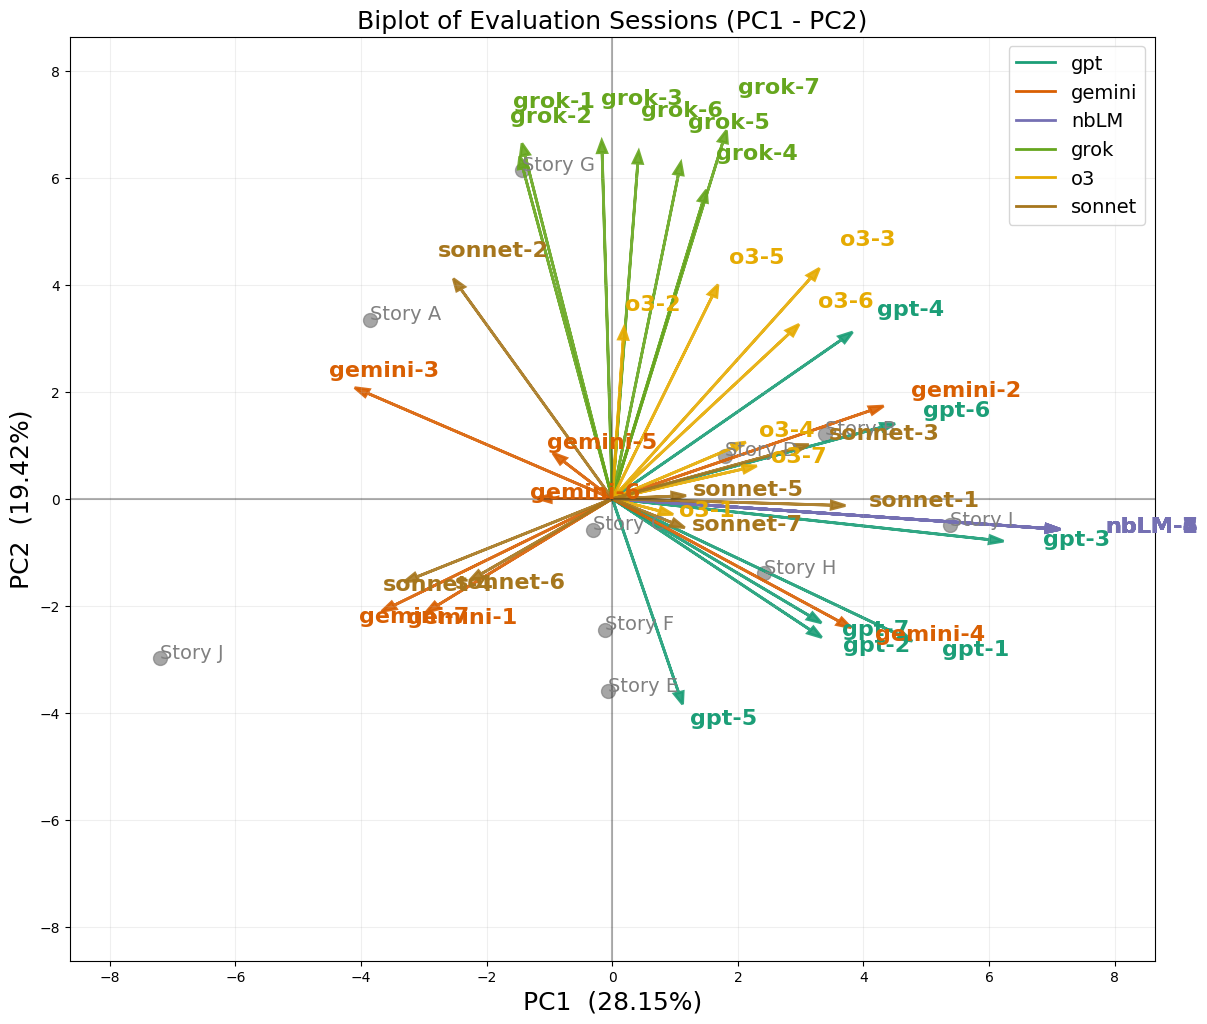

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load data from CSV
df = pd.read_csv('official_row_data.csv', encoding='utf-8')

# Create a pivot table with 'story' as row index, and 'model-session' as columns
df_cross = (
    df
    .set_index(['story', 'model', 'session'])['score']
    .unstack(['model', 'session'])
    .reset_index()
)

# Rename columns to 'model-session' format
df_cross.columns = [
    col if isinstance(col, str) else f"{col[0]}-{col[1]}"
    for col in df_cross.columns
]

# Save story titles and extract numeric matrix
story_titles = df_cross['story-'].values
X = df_cross.drop('story-', axis=1).values
feature_names = df_cross.columns[1:].tolist()

# Standardize the data (z-score)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA()
principal_components = pca.fit_transform(X_scaled)

# Calculate explained variance
eigenvalues = pca.explained_variance_
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Compute factor loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Assign colors to models
unique_models = df['model'].unique()
cmap = plt.cm.get_cmap('Dark2')
model_color_dict = {
    model: cmap(i / len(unique_models))
    for i, model in enumerate(unique_models)
}

# Define model shorthand names
model_short_names = {}
for model in unique_models:
    if 'GPT' in model:
        model_short_names[model] = 'gpt'
    elif 'Gemini' in model:
        model_short_names[model] = 'gemini'
    elif 'Notebook' in model:
        model_short_names[model] = 'nbLM'
    elif 'Open' in model:
        model_short_names[model] = 'o3'
    elif 'Grok' in model:
        model_short_names[model] = 'grok'
    elif 'Sonnet' in model:
        model_short_names[model] = 'sonnet'
    else:
        model_short_names[model] = model

# Create biplot
fig = plt.figure(figsize=(14, 12))
ax = plt.subplot(111)

# Plot stories as gray points
for i, title in enumerate(story_titles):
    plt.scatter(principal_components[i, 0], principal_components[i, 1], 
                c='gray', s=100, alpha=0.7)
    plt.annotate(title, (principal_components[i, 0], principal_components[i, 1]), 
                 fontsize=14, color='gray')

# Plot feature vectors (loadings)
scaling_factor = 7

for model in unique_models:        
    model_features = [f for f in feature_names if f.startswith(model)]
    for feature in model_features:
        i = feature_names.index(feature)
        plt.arrow(0, 0, loadings[i, 0] * scaling_factor, loadings[i, 1] * scaling_factor, 
                  color=model_color_dict[model], alpha=0.9, head_width=0.15, 
                  linewidth=2.0, length_includes_head=True, 
                  label=model if feature == model_features[0] else "")

        session_id = feature.split('-')[-1]
        short_label = f"{model_short_names[model]}-{session_id}"

        plt.text(loadings[i, 0] * scaling_factor * 1.1, loadings[i, 1] * scaling_factor * 1.1, 
                 short_label, color=model_color_dict[model], fontsize=16, fontweight='bold')

# Legend
handles = [plt.Line2D([0], [0], color=model_color_dict[m], lw=2) for m in unique_models]
labels = [model_short_names[m] for m in unique_models]
plt.legend(handles, labels, loc='best', fontsize=14)

# Axis and labels
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.xlabel(f'PC1  ({explained_variance[0]*100:.2f}%)', fontsize=18)
plt.ylabel(f'PC2  ({explained_variance[1]*100:.2f}%)', fontsize=18)
plt.title('Biplot of Evaluation Sessions (PC1 - PC2)', fontsize=18)
plt.grid(True, alpha=0.2)

# Auto-scale limits based on max value in components and loadings
margin = 1.2
max_val = max(
    abs(principal_components[:, 0].min()), 
    abs(principal_components[:, 0].max()),
    abs(principal_components[:, 1].min()), 
    abs(principal_components[:, 1].max()),
    abs(loadings[:, 0].min() * scaling_factor),
    abs(loadings[:, 0].max() * scaling_factor),
    abs(loadings[:, 1].min() * scaling_factor),
    abs(loadings[:, 1].max() * scaling_factor)
) * margin

plt.xlim(-max_val, max_val)
plt.ylim(-max_val, max_val)

print("Figure 4-4")
plt.show()
